In [1]:
from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from ptb_lstm import LSTMModel
from lang_util import Corpus
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from functools import reduce, partial
import matplotlib.pyplot as plt

In [2]:
corpus = Corpus('/Users/jgordon/nta/datasets/PTB')

In [6]:
import rsm_samplers
import rsm
reload(rsm_samplers)
reload(rsm)

BS = 2
SEQL = 3
VS = 10000
EMB_DIM = 30

vector_dict = {}
for i in range(VS):
    random_binary = torch.FloatTensor(EMB_DIM).uniform_() > 0.85
    vector_dict[i] = random_binary

model = rsm.RSMLayer(d_in=EMB_DIM, d_out=EMB_DIM, embed_dim=EMB_DIM)
collate_fn = partial(rsm_samplers.ptb_pred_sequence_collate, vector_dict=vector_dict)

sampler = rsm_samplers.PTBSequenceSampler(corpus.train, batch_size=BS, seq_length=SEQL)
loader = DataLoader(corpus.train,
                       batch_sampler=sampler,
                       collate_fn=collate_fn)


In [4]:
batch = next(iter(loader))

data, target, pred_target = batch
print(data.size())
print(target.size())
print(pred_target.size())

torch.Size([3, 2, 30])
torch.Size([3, 2, 30])
torch.Size([3, 2, 30])


In [7]:
batch = next(iter(loader))
inputs, target, pred_target = batch
hidden = model.init_hidden(BS)
x_a, hidden, x_b = model(inputs.float(), hidden)
print(x_a.size())

torch.Size([3, 2, 30])


In [12]:
import rsm_samplers
reload(rsm_samplers)

from torch.utils.data import DataLoader, BatchSampler

dataset = datasets.MNIST("~/nta/datasets", download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]),)

sl = 12
bs = 10
sampler = rsm_samplers.MNISTSequenceSampler(dataset, batch_size=bs, sequences=[[0,1,2,3],[0,1,2,3],[0,3,2,1]], randomize_sequences=True)
batch_sampler = BatchSampler(sampler, batch_size=sl * bs + 1, drop_last=True)

collate_fn = partial(rsm_samplers.pred_sequence_collate, 
                     bsz=bs,
                     seq_length=sl)
loader = DataLoader(dataset,
                               batch_sampler=batch_sampler,
                               collate_fn=collate_fn)
model = rsm.RSMLayer()

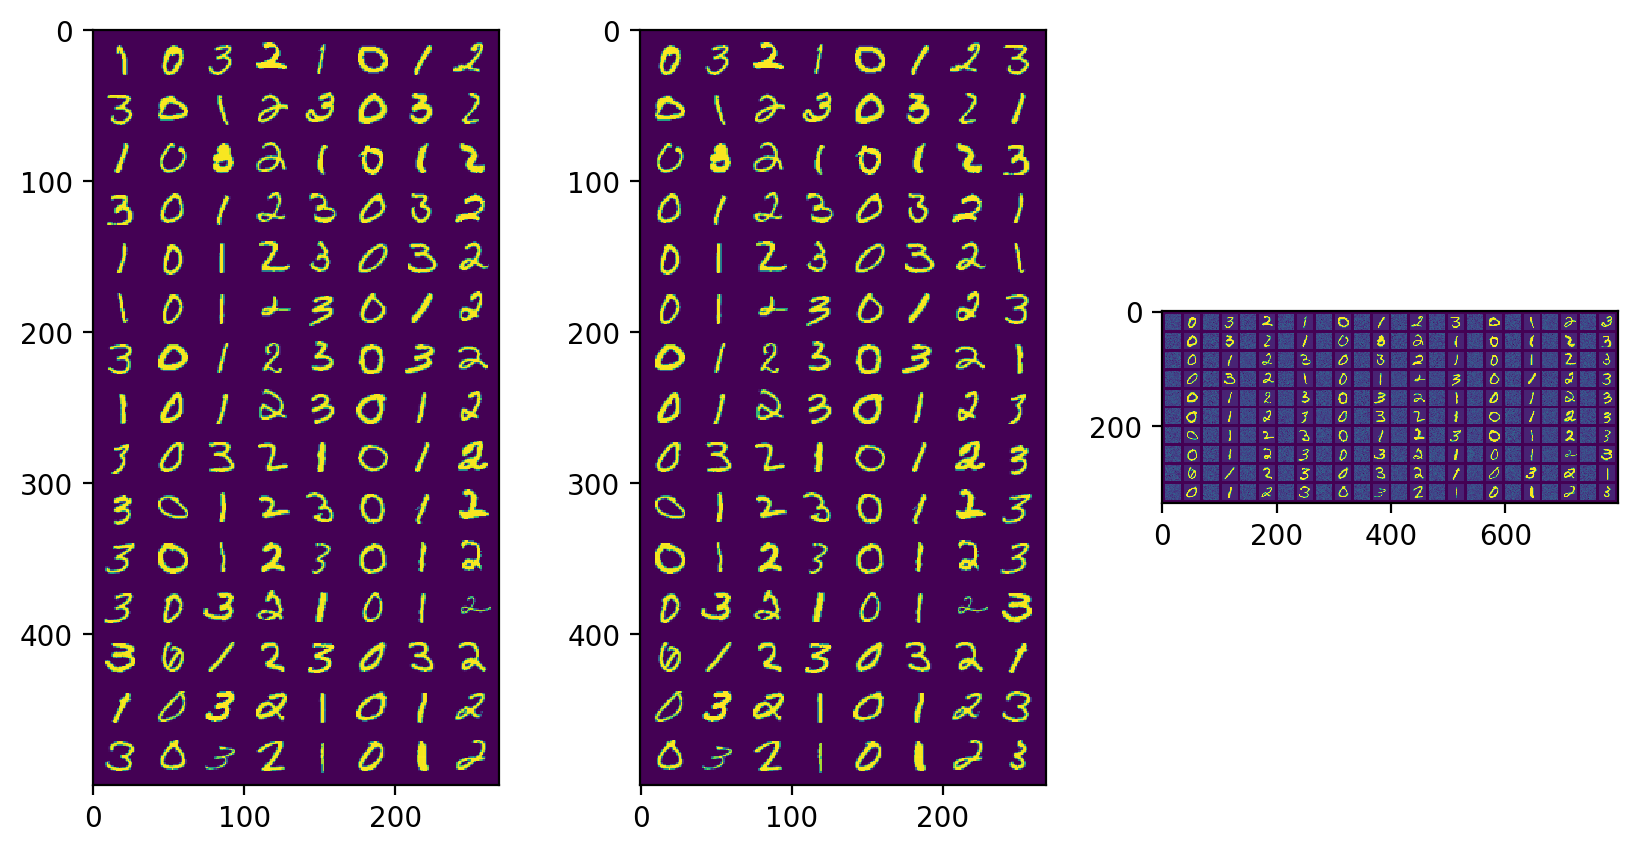

tensor([[0, 3, 2, 1, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 3, 2, 1],
        [0, 3, 2, 1, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 3, 2, 1],
        [0, 1, 2, 3, 0, 3, 2, 1],
        [0, 1, 2, 3, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 3, 2, 1],
        [0, 1, 2, 3, 0, 1, 2, 3],
        [0, 3, 2, 1, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 1, 2, 3],
        [0, 3, 2, 1, 0, 1, 2, 3],
        [0, 1, 2, 3, 0, 3, 2, 1],
        [0, 3, 2, 1, 0, 1, 2, 3],
        [0, 3, 2, 1, 0, 1, 2, 3]])


In [24]:
import torchvision.utils as vutils
import numpy as np

data, target, pred_target = next(iter(loader))
hidden = model.init_hidden(bs)
x_a_next, hidden, x_bs = model(data, hidden)

fig, axs = plt.subplots(1, 3, figsize=(10, 5), dpi=200)

grid = vutils.make_grid(data.view(-1, 1, 28, 28), normalize=True, padding=5)
grid = np.transpose(grid.numpy(), (1, 2, 0)).mean(axis=2)
axs[0].imshow(grid)

grid = vutils.make_grid(target.view(-1, 1, 28, 28), normalize=True, padding=5)
grid = np.transpose(grid.numpy(), (1, 2, 0)).mean(axis=2)
axs[1].imshow(grid)

def interleave(A, B):
    side = B.shape[2]
    C = torch.empty((A.shape[0]+B.shape[0],A.shape[1], side, side))
    C[::2,:,:] = A
    C[1::2,:,:] = B
    return C
compare = interleave(x_a_next.detach().view(-1, 1, 28, 28), target.view(-1, 1, 28, 28))
grid = vutils.make_grid(compare, normalize=True, nrow=12*2, padding=5)
grid = np.transpose(grid.numpy(), (1, 2, 0)).mean(axis=2)
axs[2].imshow(grid)


plt.show()

print(pred_target.reshape(-1, 8))

In [ ]:
# MNIST Tests

import rsm_samplers 
reload(rsm)
reload(rsm_samplers)

SEQL = 3
BS = 4

model = rsm.RSMLayer(d_in=28 ** 2, m=4, n=3, k=2, batch_size=BS, k_winner_cells=2, debug=False)

dataset = datasets.MNIST("~/nta/datasets", download=True,
                                          train=True, transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.1307,), (0.3081,))
                                          ]),)

sampler = rsm_samplers.MNISTSequenceSampler(dataset, batch_size=BS, sequences=[[1,2,3]])
batch_sampler = BatchSampler(sampler, batch_size=BS * SEQL + 1, drop_last=True)

loader = DataLoader(dataset,
                       batch_sampler=batch_sampler,
                       collate_fn=rsm_samplers.pred_sequence_collate)
criterion = CrossEntropyLoss()

hidden = model.init_hidden(BS)

for i, (data, targets, pred_targets) in enumerate(loader):
    print(data.size(), targets.size(), pred_targets.size())
    model.zero_grad()
    output, hidden, _ = model(data, hidden)
    if i > 3:
        break


In [ ]:
a = torch.randn(2, 12).reshape(2, 4, 3)
print(a)
values, indices = torch.topk(a, 2)
print(indices)
arr = a.new_zeros(a.size())  # Zeros, conserve device
arr.scatter_(2, indices, 1)

In [ ]:
len(corpus.dictionary)

In [ ]:
[len(corpus.train), len(corpus.valid), len(corpus.test)]

In [ ]:
batch_size = 300
batches = len(corpus.train) / batch_size
0.25 * batches

In [ ]:
from torch.nn.functional import softmax

def topk_mask(a, k, dim=0, do_softmax=False):
    """
    Return a 1 for the top b elements in the last dim of a, 0 otherwise
    """
    if do_softmax:
        return softmax(a)
    else:
        values, indices = torch.topk(a, k)
    arr = a.new_zeros(a.size())  # Zeros, conserve device
    arr.scatter_(dim, indices, 1)
    return arr

a = torch.randn((3, 4))
print(a)
topk_mask(a, 1, dim=1, do_softmax=True)

In [ ]:
from torch import nn
from copy import deepcopy
import matplotlib.pyplot as plt

class LocalLinear(nn.Module):
    """
    """
    def __init__(self, in_features, local_features, kernel_size, stride=1, bias=True):
        super(LocalLinear, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

        fold_num = (in_features - self.kernel_size) // self.stride + 1
        self.lc = nn.ModuleList([deepcopy(nn.Linear(kernel_size, local_features, bias=bias))
                                 for _ in range(fold_num)])

    def forward(self, x):
        x = x.unfold(-1, size=self.kernel_size, step=self.stride)
        fold_num = x.shape[1]
        x = torch.cat([self.lc[i](x[:, i, :]) for i in range(fold_num)], 1)
        return x


class ActiveDendriteLayer(torch.nn.Module):
    """
    Local layer for active dendrites. Similar to a non-shared weight version of a 
    2D Conv layer.
    
    Note that dendrites are fully connected to input, local layer used only for connecting
    neurons and their dendrites
    """
    def __init__(self, input_dim, n_cells=50, n_dendrites=3):
        super(ActiveDendriteLayer, self).__init__()
        self.n_cells = n_cells
        self.n_dendrites = n_dendrites
        
        total_dendrites = n_dendrites * n_cells
        self.linear_dend = nn.Linear(input_dim, total_dendrites)
        self.linear_neuron = LocalLinear(total_dendrites, 1, n_dendrites, stride=n_dendrites)
        
    def __repr__(self):
        return "ActiveDendriteLayer neur=%d, dend per neuron=%d" % (self.n_cells, self.n_dendrites)
    
    def forward(self, x):
        x = F.relu(self.linear_dend(x))
        x = self.linear_neuron(x)
        return x
 
x = torch.randn(1, 5)
print(x)
adl = ActiveDendriteLayer(5, 4, 2)
print(adl(x))


In [ ]:
x = torch.randn(5, 3)
x[:, -2:] = 1
print(x)

In [33]:
class BitwiseWordEmbedding(object):

    def __init__(self, vocab_size=10000, dim=28):
        self.vocab_size = vocab_size
        self.embedding_dict = {}
        self.dim = dim

    def generate_embeddings(self):
        for i in range(self.vocab_size):
            self.embedding_dict[i] = self.embed(i)

    def embed(self, i):
        first = "{0:b}".format(i).zfill(self.dim // 2)
        return first + self.inverse(first)

    def inverse(self, binstr):
        return ''.join('1' if x == '0' else '0' for x in binstr)

bwe = BitwiseWordEmbedding()

bwe.embed(9381)

'1001001010010101101101011010'

[[[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 ...

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]]


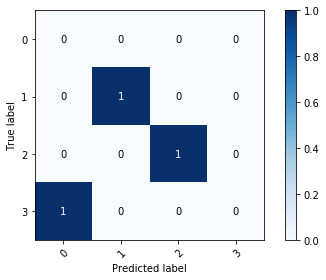

In [81]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO
from viz_util import plot_confusion_matrix, fig2img
import io


ax, fig = plot_confusion_matrix(np.array([1,2,3]), np.array([1,2,0]), ['0', '1', '2', '3'])

img = fig2img(fig)

# plt.imsave('test.png', img, format='png')

print(str(img))